In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time

from libworm.model.beta_neuron import NeuronNetwork, from_connectome
from libworm.data import connectomes, traces
from libworm import preprocess
from libworm.functions import set_neurons, tcalc_s_inf, set_trace
from libworm.data.neuron import full_sensory_list

from math import tau

In [2]:
def setup():
    _, trace, trace_labels, label2index, timestamps = traces.load_trace()
    timestamps = timestamps - timestamps[0]
    
    chemical, gapjn = connectomes.load_cook_connectome()
    neurons = connectomes.get_main_neurons(chemical, gapjn)
    neurons.sort(key=lambda item: f"AAA{label2index[item]:04d}{item}" if item in label2index else item)
    model = from_connectome(chemical, gapjn, neurons, V_value=0.0)
    
    cell = "SMBVR"
    
    not_in_main_section = [label2index[key] for key in label2index if key not in neurons]
    not_labelled = [i for i, _ in enumerate(trace[:, 0]) if i not in label2index.values()]
    
    removal = list(set(not_in_main_section).union(not_labelled))
    
    trace = np.delete(trace, removal, axis=0)
    
    trace_pairs = [(time, trace[:, i]) for i, time in enumerate(timestamps)]

    return model, trace_pairs, neurons

In [3]:
def eval(model, start_index, data):

    for i in range(15):
        runtime =  data[start_index + i + 1][0] - data[start_index + i][0]
        points = data[start_index + i][1]
        model.big_V[:len(points)] = points
        model.simple_run(0.01, runtime, show_progress=False)

    start_index += 15
    
    for i in range(15):
        runtime =  data[start_index + i + 1][0] - data[start_index + i][0]
        model.simple_run(0.01, runtime, show_progress=False)

    

## Standard Eval Trace Data

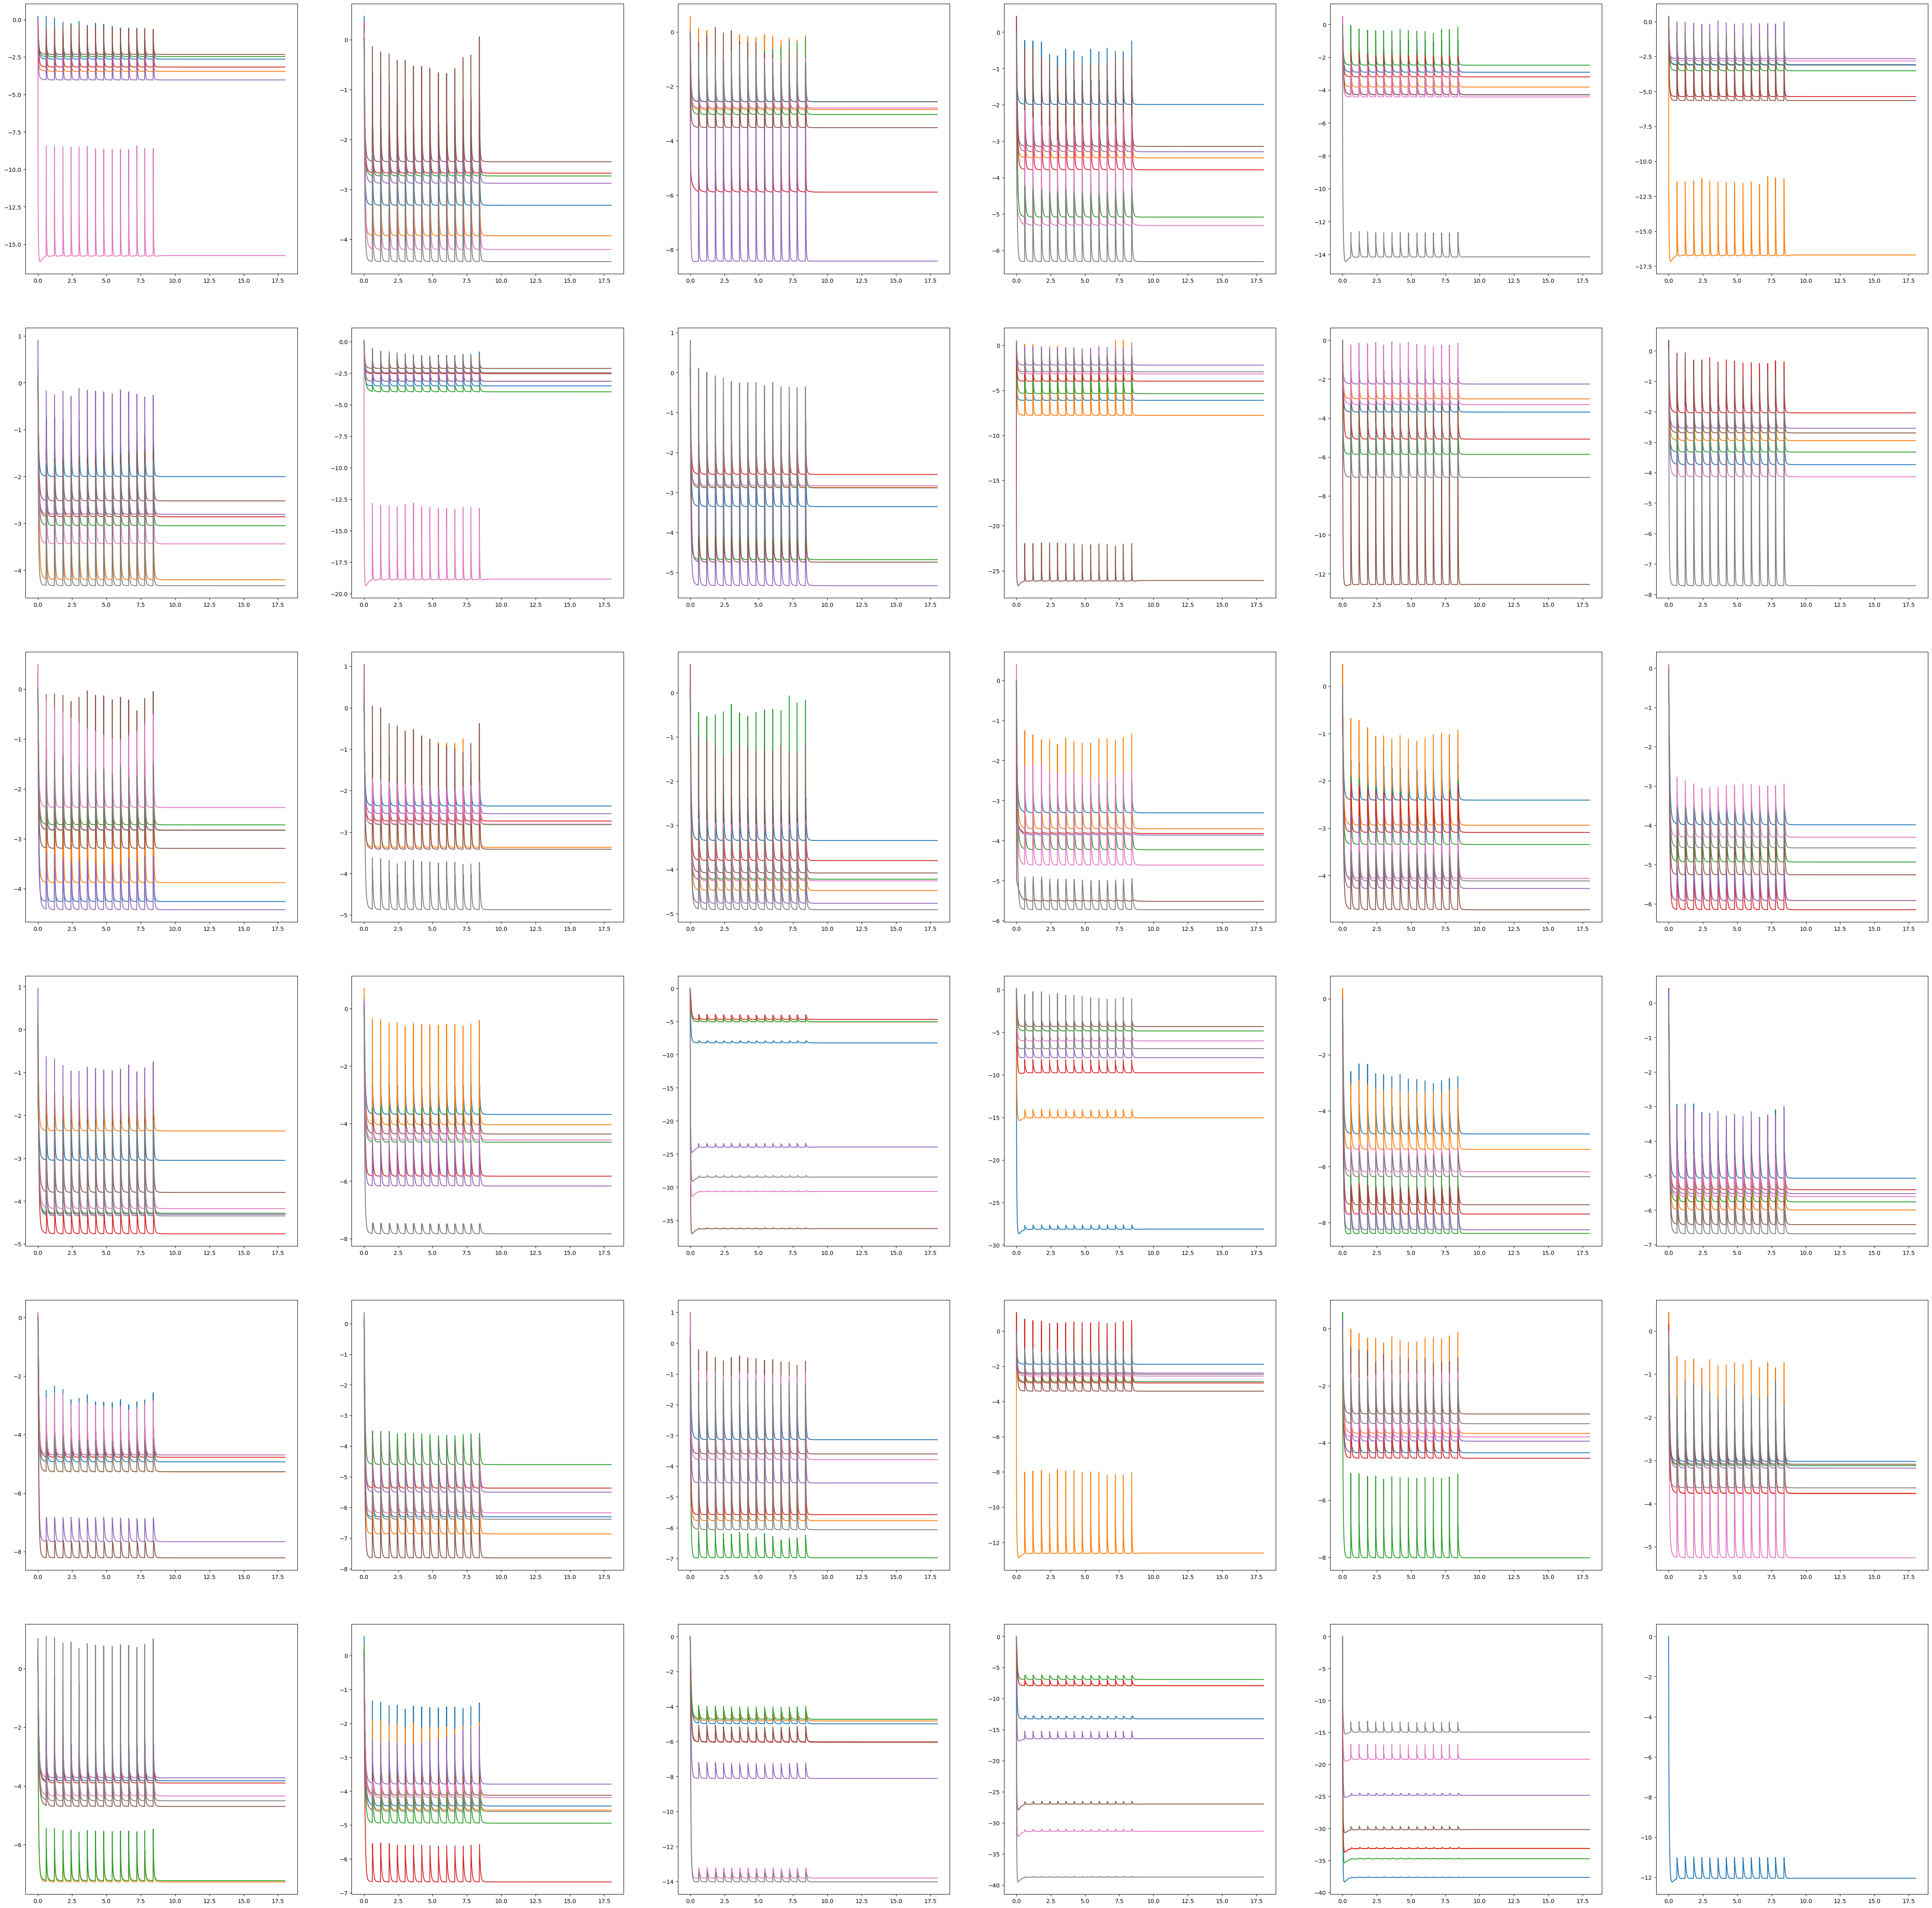

In [4]:
model, data, neurons = setup()
eval(model, 0, data)
model.show_large_voltage_data()

## Sensory Oscillator

In [5]:
sensory_indices = [neurons.index(cell) for cell in full_sensory_list]

def oscillator(time):
    value = np.clip((np.sin(time * tau) * 1000.0), 0, 1) * 1000.0
    return [0 if i not in sensory_indices else value for i in range(280)]

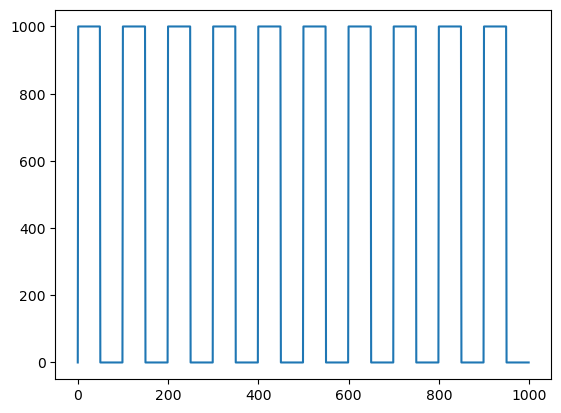

In [6]:
test = np.array([oscillator(t) for t in np.linspace(0, 10, 1000)])
plt.plot(test[:, 1])

In [ ]:
model, data, neurons = setup()
model.adv_run(0.01, 10.0, oscillator)
model.show_large_voltage_data()

## Sensory Oscillator With Offset

In [83]:
sensory_indices = [neurons.index(cell) for cell in full_sensory_list]

def oscillator_with_offset(time):
    value = lambda a: np.clip((np.sin(time * tau + a) * 1000.0), 0, 1) * 1000.0
    return [0 if i not in sensory_indices else value(i) for i in range(280)]

##########

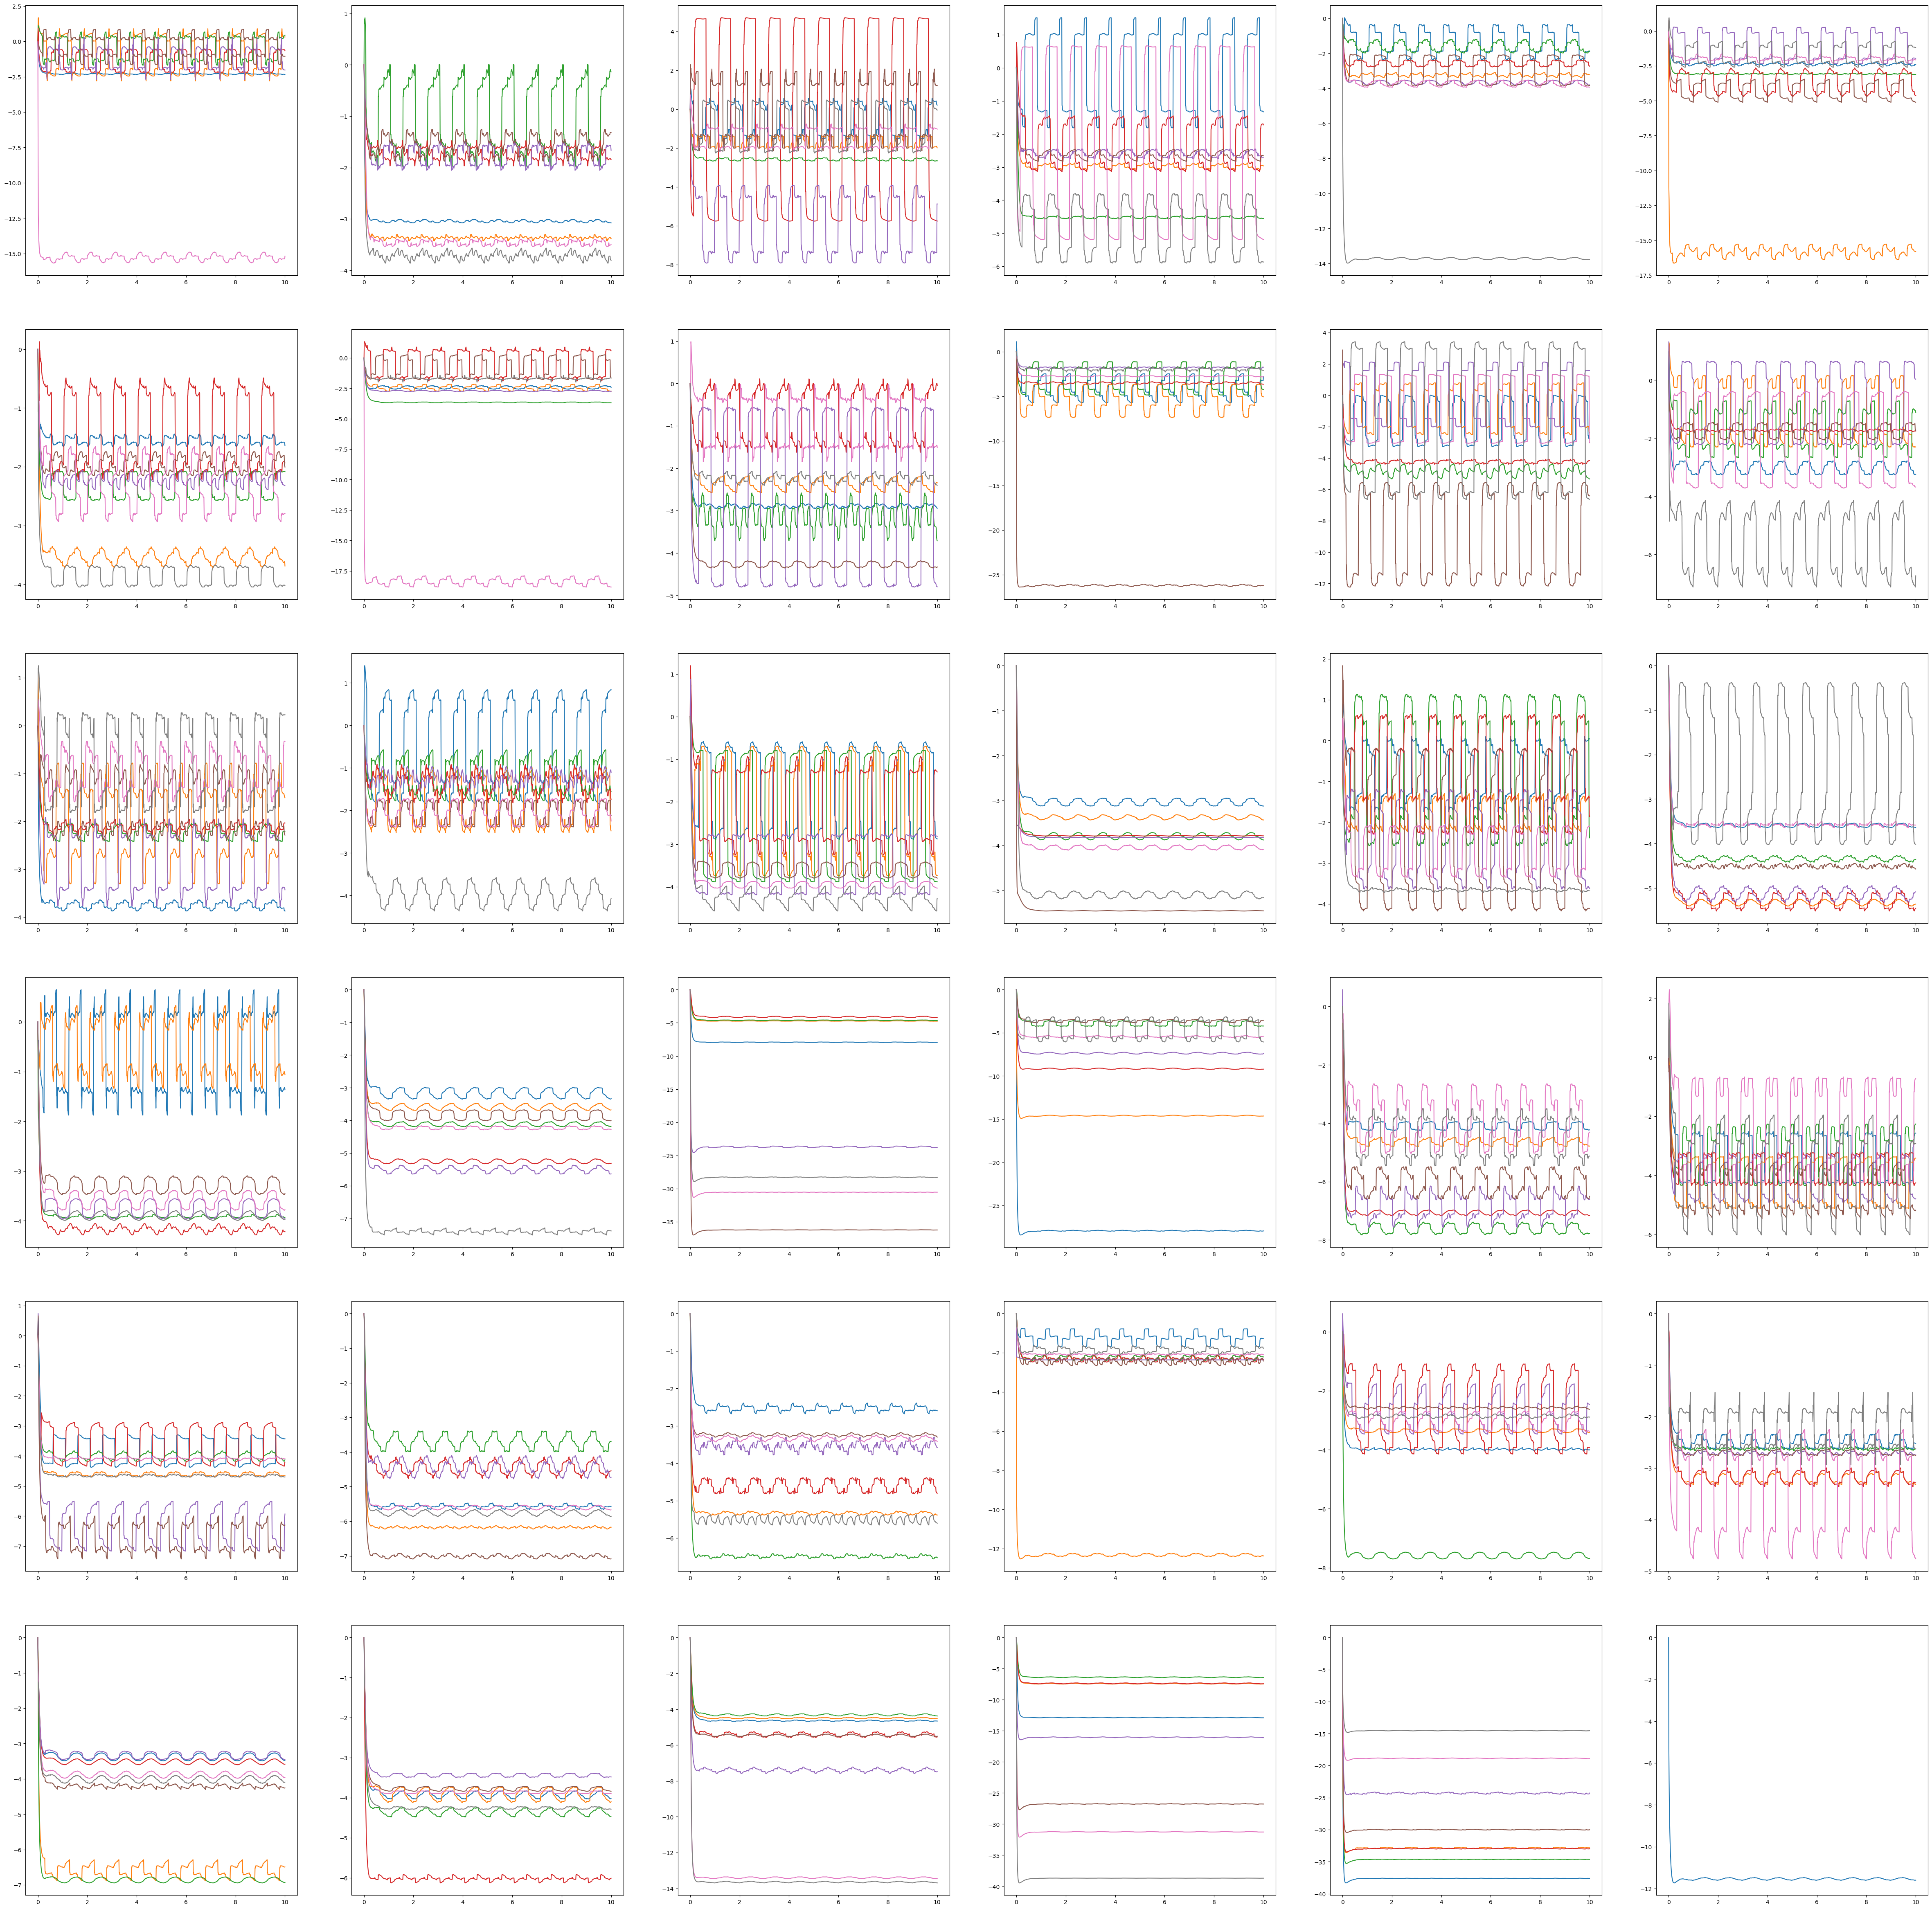

In [84]:
model, data, neurons = setup()
model.adv_run(0.01, 10.0, oscillator_with_offset)
model.show_large_voltage_data()

## Sensory Input From Trace w/ Interpolation

In [7]:
model, data, neurons = setup()

sensory_indices = [neurons.index(cell) for cell in full_sensory_list]

def interpolated_input(time):
    
    for i, (frame_time, frame) in enumerate(data):
        if frame_time > time:
            frame_b = frame
            frame_a = data[i-1][1]

            a_time = data[i-1][0]
            diff = frame_time - a_time
            distance = (time - a_time) / diff
            break
    
    return [(frame_a[i] * (1-distance) + frame_b[i] * distance) * 1000.0 if i < len(frame_a) and i in sensory_indices else 0 for i in range(280)]



In [9]:
re_trace = np.array([frame for time, frame in data])

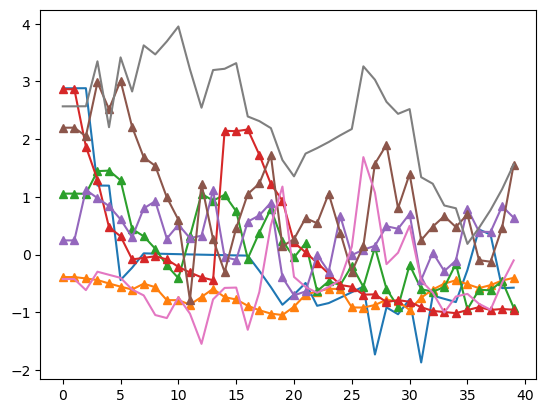

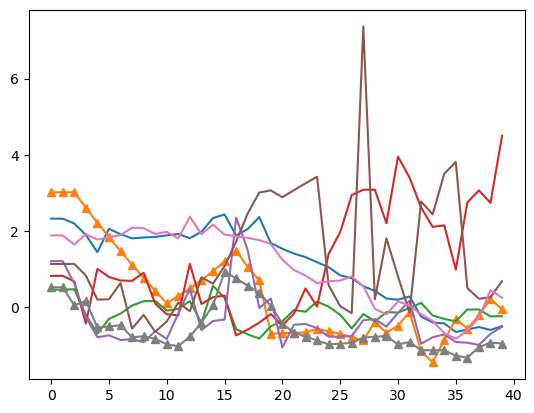

In [17]:
for i in range(8):
    if i in sensory_indices:
        plt.plot(re_trace[:40, i], marker='^')
    else:
        plt.plot(re_trace[:40, i])

plt.show()

for i in range(8, 16):
    if i in sensory_indices:
        plt.plot(re_trace[:40, i], marker='^')
    else:
        plt.plot(re_trace[:40, i])

plt.show()

##########

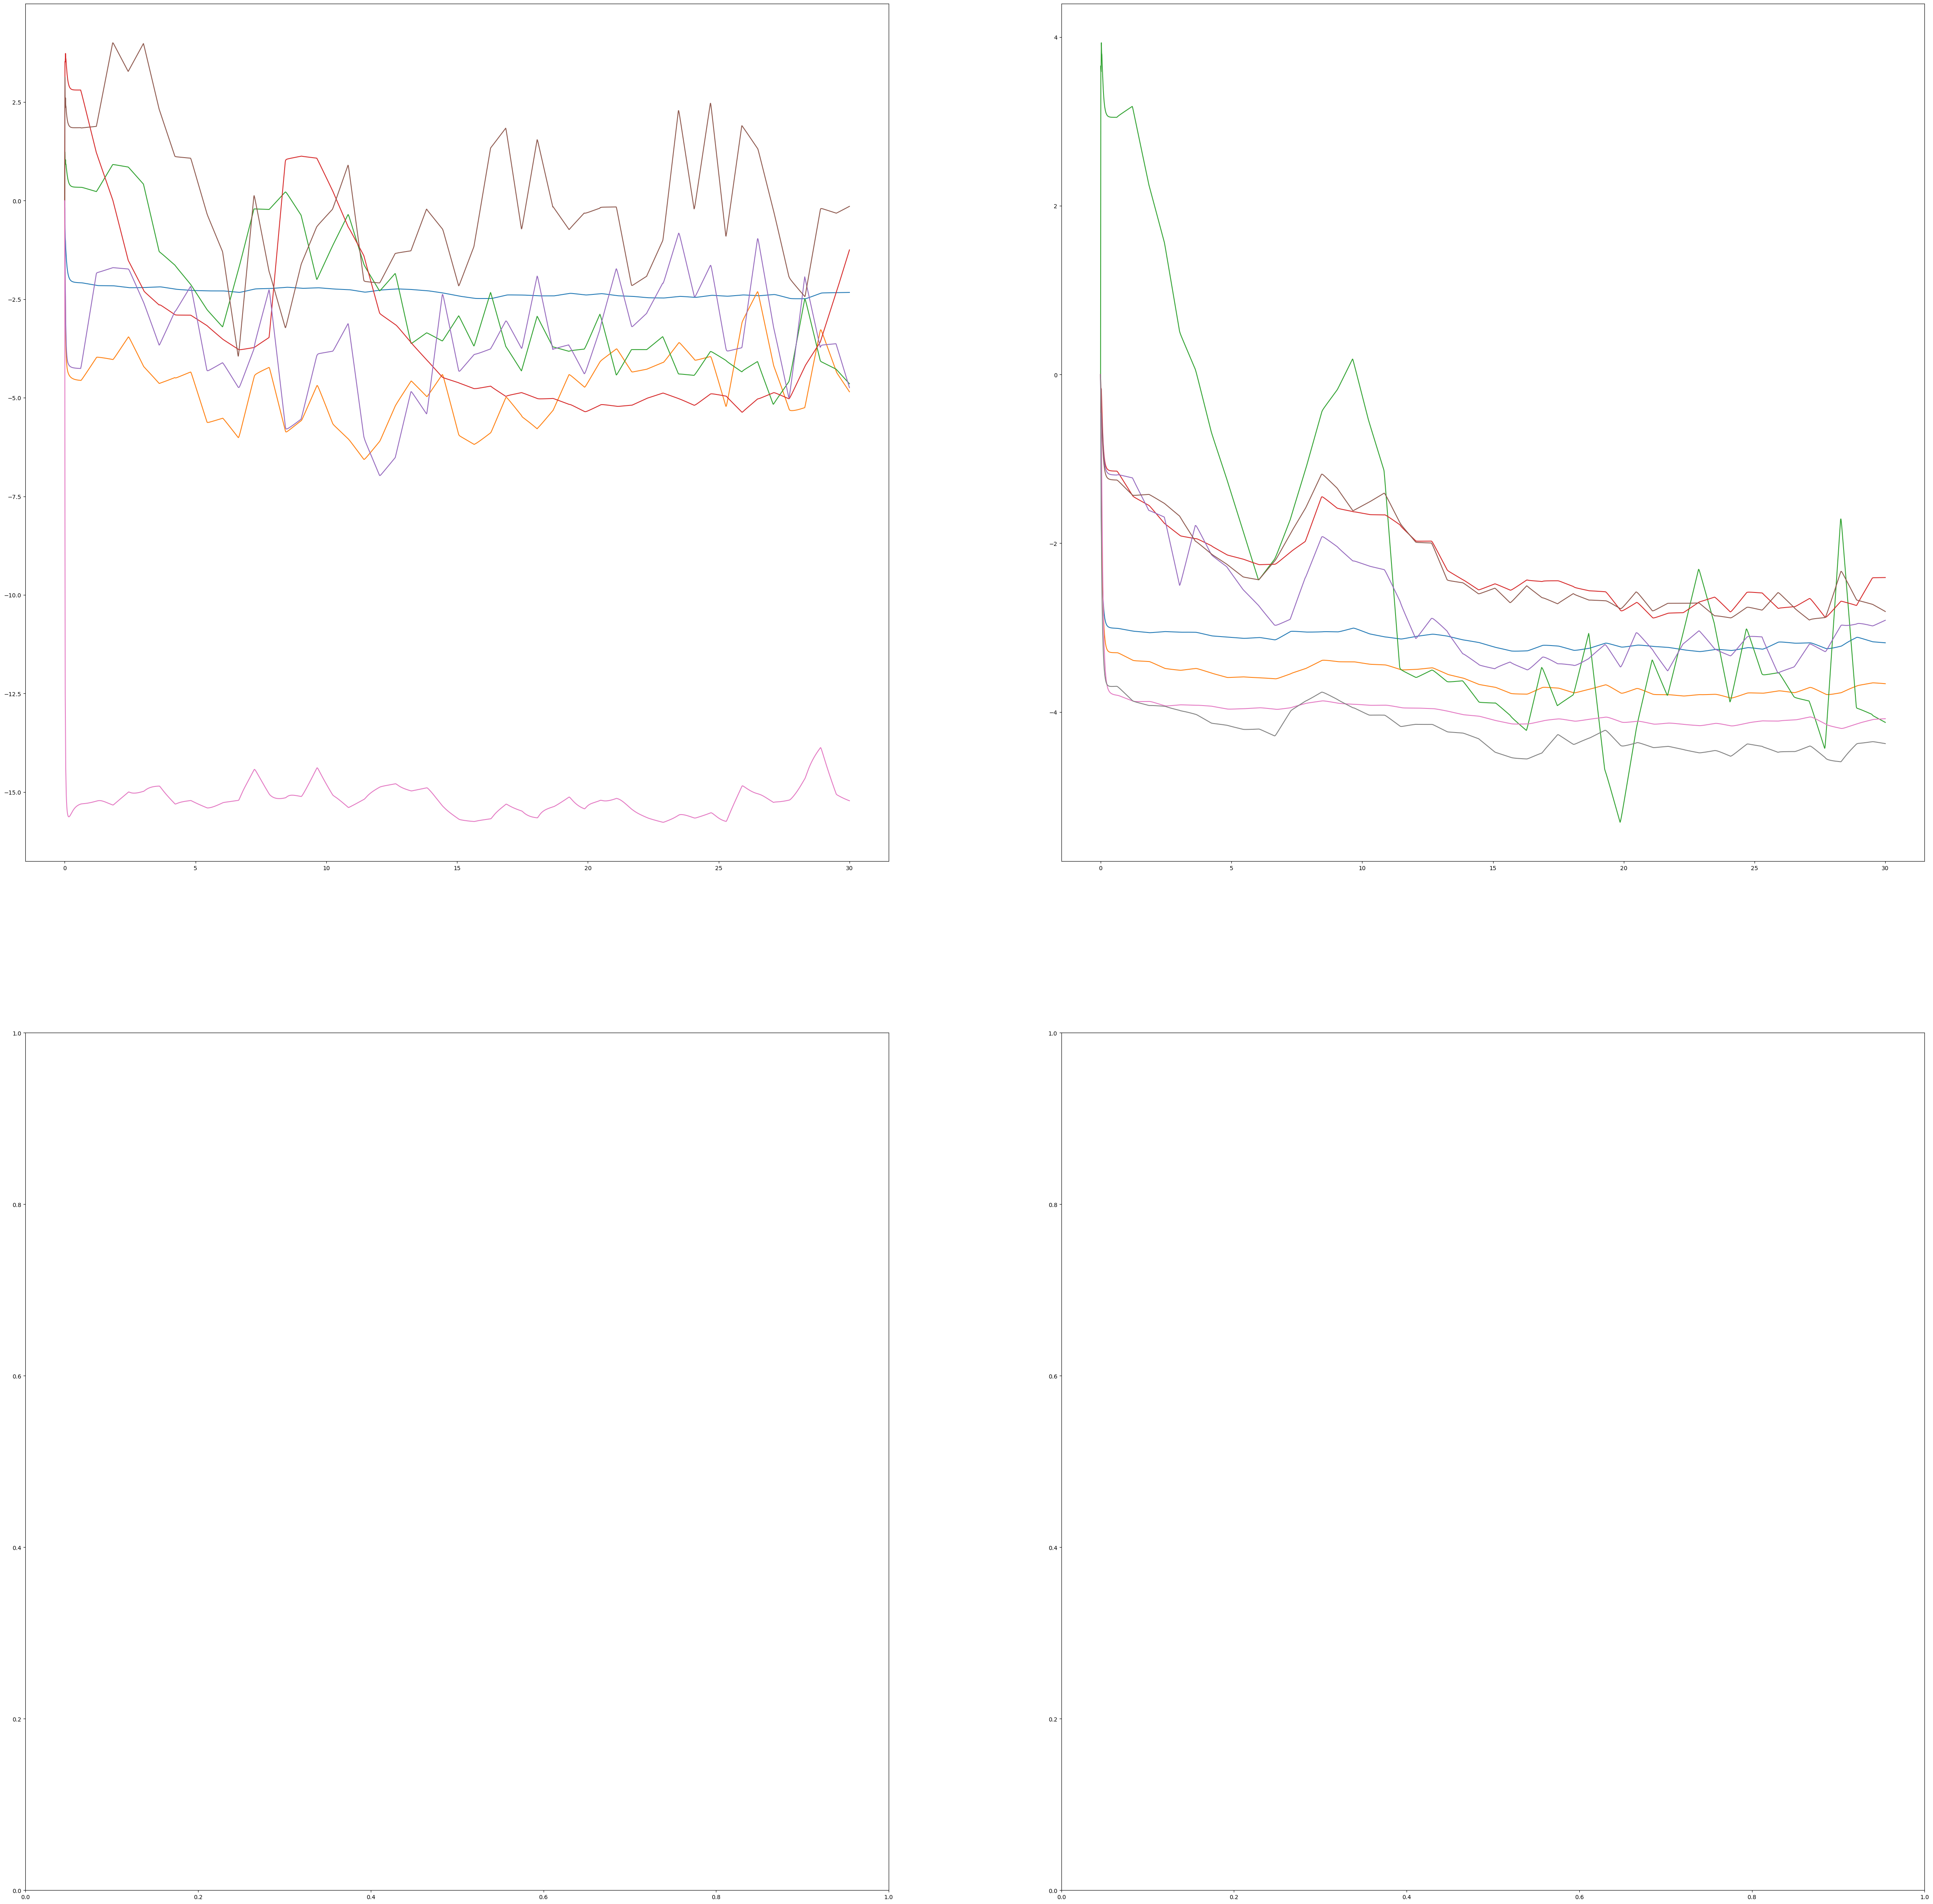

In [16]:
model.adv_run(0.01, 10.0, interpolated_input)

model.show_large_voltage_data(count = 15)